In [1]:
%matplotlib inline

In [2]:
from matplotlib.pylab import *

In [3]:
rc('figure', figsize=(8, 4))
rc('savefig', bbox='tight')
plt.rcParams.update({'font.size': 16})

import numpy as np
import torch
import torch.nn as nn
from models import resnet18_narrow as resnet18
from utils import get_loader
from utils.train_utils import AverageMeter, accuracy
import argparse
from sklearn.model_selection import ParameterGrid
import pickle
from tqdm import tqdm 
import copy
import glob
import numpy as np
import scipy
import copy

In [4]:
all_measures = ["eps_flat", "pac_bayes", "fro_norm", "fim", "local_entropy_grad_norm", "shannon_entropy", "eig_trace", "low_pass"]
labels = ["$\epsilon$ sharpness", "Pac Bayes", "$||H||_{F}$", "Fisher norm", "Local entropy Grad", "Classical Entropy", "Trace", "Low pass filter"]
ln = [i/10 for i in range(10)]

gen_gap = np.zeros((10, 5)) # measures x noise x seed 
sharpness = np.zeros((len(all_measures), 10, 5)) # measures x noise x seed 

for k in range(5):
    for j in range(10):
        fol = f"checkpoints/cifar10_label_noise/resnet_label_noise_{j / 10}/run_ms_{k}/measures.pkl"
        with open(fol, 'rb') as f:
            mtr = pickle.load(f)    
        gen_gap[j,k] = (-mtr["val_acc"] + mtr["train_acc"])
        for i,meas in enumerate(all_measures, 0):
            sharpness[i,j,k] = mtr[meas]

sharpness_mean = np.mean(sharpness, 2)
sharpness_std = np.std(sharpness, 2)
sharpness_mean = sharpness_mean - np.min(sharpness_mean, 1).reshape(-1,1)
sharpness_mean = sharpness_mean / np.max(sharpness_mean, 1).reshape(-1,1)
# sharpness = sharpness_mean

gen_gap = np.mean(gen_gap, 1)

[2.15386731 5.05107223 3.24711407 3.64287962 2.32172894 2.43670046
 3.41750005 3.36442642 3.57068937 3.21405701]


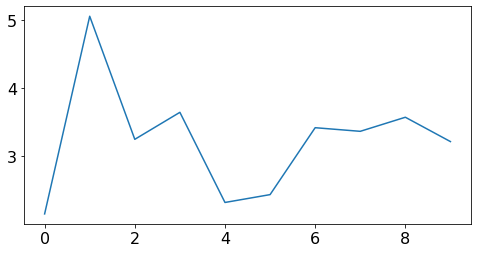

In [8]:
print(sharpness[0,:,0])
plt.plot(sharpness[0,:,0])

$\epsilon$ sharpness & Pac Bayes & $||H||_{F}$ & Fisher norm & Local entropy & Classical Entropy & Trace & Low pass filter & 
-0.1254 & 0.9216 & 0.8384 & 0.7673 & 0.6763 & -0.1809 & 0.8158 & 0.9506 & 

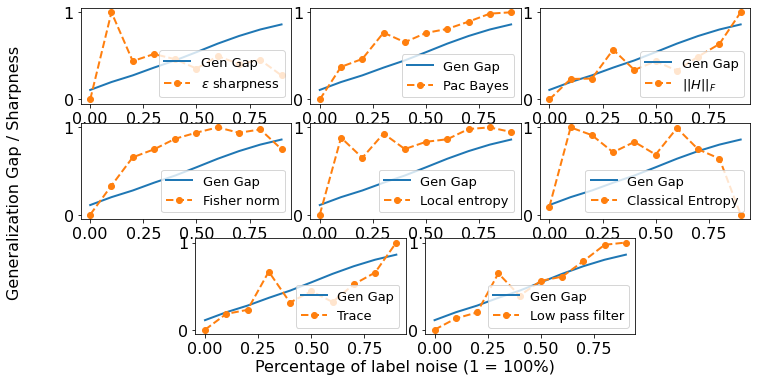

In [7]:
labels = ["$\epsilon$ sharpness", "Pac Bayes", "$||H||_{F}$", "Fisher norm", "Local entropy", "Classical Entropy", "Trace", "Low pass filter"]

fig = plt.figure(figsize=(12, 6))
ax1 = plt.subplot2grid(shape=(3,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((3,6), (0,2), colspan=2, sharex=ax1)
ax3 = plt.subplot2grid((3,6), (0,4), colspan=2, sharex=ax1)
ax4 = plt.subplot2grid((3,6), (1,0), colspan=2, sharex=ax1)
ax5 = plt.subplot2grid((3,6), (1,2), colspan=2, sharex=ax1)
ax6 = plt.subplot2grid((3,6), (1,4), colspan=2, sharex=ax1)
ax7 = plt.subplot2grid((3,6), (2,1), colspan=2, sharex=ax1)
ax8 = plt.subplot2grid((3,6), (2,3), colspan=2, sharex=ax1)
axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
# ax.plot(widths, gen_gap, linewidth=2, marker='o')

for i,meas in enumerate(all_measures,0):
    axs[i].plot(ln, gen_gap/100, label=f"Gen Gap",linewidth=2)
    axs[i].plot(ln, sharpness[i,:], label=f"{labels[i]}",linewidth=2, marker='o', linestyle="--")
    axs[i].legend(fontsize=13, loc=4)

fig.text(0.5, 0.04, 'Percentage of label noise (1 = 100%)', ha='center')
fig.text(0.04, 0.5, 'Generalization Gap / Sharpness', va='center', rotation='vertical')
fig.savefig("results/ln.png")

for i,meas in enumerate(all_measures,0):
    print(f"{labels[i]} & ", end="")
print("")
for i,meas in enumerate(all_measures,0):
    print(f"{scipy.stats.pearsonr(ln, sharpness_mean[i,:])[0]:0.4f} &", end=' ')